# Multi-modal Embedding using CLIP-16

## Imports and Utilities

In [1]:
from sentence_transformers import SentenceTransformer, util, models, InputExample, losses
from PIL import Image
import glob
import torch
from torch.utils.data import DataLoader
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import pandas as pd
import os
from tqdm.autonotebook import tqdm, trange
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [2]:
image_folder = 'images/'
def show_image(img_id, img_folder=image_folder):
    try:
        image_link = img_folder + img_id + '.jpg'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    except:
        image_link = img_folder + img_id + '.png'
        plt.title("Image")
        plt.xlabel("X pixel scaling")
        plt.ylabel("Y pixels scaling")

        image = mpimg.imread(image_link)
    plt.imshow(image)
    plt.show()

In [3]:
import random
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [4]:
df = pd.read_csv('data/tweets_subset.csv', index_col='Unnamed: 0').reset_index()
df[df.available].head()

,index,id,skepticism,mainstream,label,text_NL,text_EN,split,available,target,unseen_images
956,956,327027443732983808,False,True,1,"RT @USER : 3D waterkaart , hoe stroomt het wat...","RT @USER : 3D water map , how the water flows ...",test,True,3_327026285966667776,1
1211,1211,375896131127218176,False,True,1,Kom naar de Wilhelminakade R'dam en klim boven...,Come to the Wilhelminakade R'dam and climb abo...,val,True,3_375896131013971968,1
1212,1212,375899134915772416,False,True,1,RT @USER : Kom naar de Wilhelminakade R'dam en...,RT @USER : Come to the Wilhelminakade R'dam an...,val,True,3_375896131013971968,1
1214,1214,375946829881278464,False,True,1,Scholieren klimmen met Jeugdwaterschap naar ni...,Students climb to the water level of their hou...,val,True,3_375946829747089408,0
1215,1215,375946961951539200,False,True,1,RT @USER : Scholieren klimmen met Jeugdwatersc...,RT @USER : Students climb to the water level o...,train,True,3_375946829747089408,0


In [5]:
# We use the original CLIP model for computing image embeddings and English text embeddings
en_model = SentenceTransformer('clip-ViT-B-16')
tokenizer = en_model._first_module().processor.tokenizer

In [6]:
def embed_documents(documents, embedding_model=en_model, convert_to_tensor = True, verbose = False):
    """ Embed a list of n documents/words into an n-dimensional
    matrix of embeddings

    Arguments:
        documents: A list of documents or words to be embedded
        verbose: Controls the verbosity of the process

    Returns:
        Document/words embeddings with shape (n, m) with `n` documents/words
        that each have an embeddings size of `m`
    """
    truncated_docs = [truncate_document(doc) for doc in documents]
    embeddings = embedding_model.encode(truncated_docs, show_progress_bar=verbose, convert_to_tensor=convert_to_tensor)
    return embeddings

def truncate_document(document, tokenizer=tokenizer):
    tokens = tokenizer.encode(document)

    if len(tokens) > 77:
        # Skip the starting token, only include 75 tokens
        truncated_tokens = tokens[1:76]
        document = tokenizer.decode(truncated_tokens)

        # Recursive call here, because the encode(decode()) can have different result
        return truncate_document(document)

    else:
        return document

In [7]:
df['text_EN_trun'] = df['text_EN'].apply(truncate_document)

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors


In [8]:
def embed_images(images, verbose=True, batch_size=32, embedding_model=en_model, convert_to_tensor=True):
    if batch_size:
        nr_iterations = int(np.ceil(len(images) / batch_size))

        # Embed images per batch
        embeddings = []
        for i in tqdm(range(nr_iterations), disable=not verbose):
            start_index = i * batch_size
            end_index = (i * batch_size) + batch_size

            images_to_embed = [Image.open(img_name_dict[image]) if (isinstance(image, str) and not str(image)=='nan') 
                               else (Image.new('RGB', (800, 600), color = (255,255,255)) if str(image)=='nan'
                               else image) for image in images[start_index:end_index]]
            img_emb = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
            embeddings.extend(img_emb.tolist())

            # Close images
            if isinstance(images[0], str):
                for image in images_to_embed:
                    image.close()
        if not convert_to_tensor:
            embeddings = np.array(embeddings)
        else:
            embeddings = torch.tensor(embeddings).to(device='cuda')
    else:
        images_to_embed = [Image.open(filepath) for filepath in images]
        embeddings = embedding_model.encode(images_to_embed, show_progress_bar=False, convert_to_tensor=convert_to_tensor)
    return embeddings

In [9]:
def return_report(labels, preds, ids=[]):
    if len(ids)==0:
        print(metrics.classification_report(labels.cpu(), preds.cpu(), digits=4))
        return metrics.classification_report(labels.cpu(), preds.cpu(), digits=4, output_dict=True)
    else:
        print(metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4))
        return metrics.classification_report(labels[torch.tensor(list(ids))].cpu(), preds[torch.tensor(list(ids))].cpu(), digits=4, output_dict=True)

def evaluate_dataset_F1(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    test = df[df['split'] == 'test'].index
    image = df[df['available']].index
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        temp = val.copy()
    elif val_set=='test':
        temp = test.copy()
    
    a = temp.intersection(image)
    b = temp.difference(image)
    c = temp.intersection(image).intersection(unseen)    
    
    print('Overall Dataset:')
    all_report = return_report(label_all, preds_all)
    
    print('Training Set:')
    train_report = return_report(label_all, preds_all, train)
    
    print('Validation Set:')
    val_report = return_report(label_all, preds_all, temp)
    
    print('Validation Set with both Images and Texts:')
    val_img_report = return_report(label_all, preds_all, a)
    
    print('Validation Set with only Texts:')
    val_txt_report = return_report(label_all, preds_all, b)
    
    print('Validation Set with unseen Images:')
    val_unseen_report = return_report(label_all, preds_all, c)
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    val_acc = ((label_all[torch.tensor(list(temp))]==preds_all[torch.tensor(list(temp))]).sum()/len(temp)).item()*100
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_report, train_report, val_report, val_img_report, val_txt_report, val_unseen_report

In [10]:
def evaluate_dataset(df, preds_all, device = 'cuda', val_set = 'val'):
    preds_all = preds_all.float()
    label_all = torch.tensor(np.array(df['skepticism'])).to(device).float()
    #train = torch.tensor(np.array(df_all['split'] == 'train')).to(device).float()
    train = df[df['split'] == 'train'].index
    #val = torch.tensor(np.array(df_all['split'] == 'val')).to(device).float()
    val = df[df['split'] == 'val'].index
    #test = torch.tensor(np.array(df_all['split'] == 'test')).to(device).float()
    test = df[df['split'] == 'test'].index
    #image = torch.tensor(np.array(df_all['available'])).to(device).float()
    image = df[df['available']].index
    #unseen = torch.tensor(np.array(df_all['unseen_images'])).to(device).float()
    unseen = df[df['unseen_images']==1].index
    
    if val_set=='val':
        a = val.intersection(image)
        b = val.difference(image)
        c = val.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(val))]==preds_all[torch.tensor(list(val))]).sum()/len(val)).item()*100
            
    elif val_set=='test':
        a = test.intersection(image)
        b = test.difference(image)
        c = test.intersection(image).intersection(unseen)
        val_acc = ((label_all[torch.tensor(list(test))]==preds_all[torch.tensor(list(test))]).sum()/len(test)).item()*100
    
    all_acc = ((label_all==preds_all).sum()/len(preds_all)).item()*100
    train_acc = ((label_all[torch.tensor(list(train))]==preds_all[torch.tensor(list(train))]).sum()/len(train)).item()*100
    
    val_img_acc = ((label_all[torch.tensor(list((a)))]==preds_all[torch.tensor(list(a))]).sum()/len(a)).item()*100
    val_txt_acc = ((label_all[torch.tensor(list((b)))]==preds_all[torch.tensor(list((b)))]).sum()/len(b)).item()*100
    val_unseen = ((label_all[torch.tensor(list((c)))]==preds_all[torch.tensor(list((c)))]).sum()/len(c)).item()*100
    
    print('''
    Overall Accuracy: {:.2f}
    Training Set Accuracy: {:.2f}
    Validation Set Accuracy: {:.2f}
    Validation Set with both Images and Texts: {:.2f}
    Validation Set with only Texts: {:.2f}
    Validation Set with unseen Images: {:.2f}
    '''.format(all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen))
    
    return all_acc, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen

## Process Raw Data into Embeddings

Two sentences to compute embeddings

In [11]:
labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
          'Climate change is not even a real problem to concern about! I do not believe in it!']
lab_emb = en_model.encode(labels, convert_to_tensor=True)
empty_img_emb = embed_images(['nan'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
empty_img_emb.shape

torch.Size([1, 512])

In [ ]:
txt_emb = embed_documents(list(df['text_EN']), convert_to_tensor=True, verbose=True)

In [ ]:
img_emb = embed_images(list(df['target']), convert_to_tensor=True)

In [ ]:
import pickle
with open('model_storage/CLIP16/embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 
                 'lab_emb': lab_emb, 'empty_img_emb': empty_img_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('model_storage/CLIP16/embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    #stored_sentences = stored_data['sentences']
    txt_emb = stored_data['txt_emb']
    img_emb = stored_data['img_emb']
    lab_emb = stored_data['lab_emb']
    empty_img_emb = stored_data['empty_img_emb']

labs = {}
labs['txt_emb'] = lab_emb
labs['img_emb'] = torch.vstack([empty_img_emb] * lab_emb.shape[0])
mul_emb = (img_emb + txt_emb)/2

## Zero-shot Classification

Using Cosine Similarity to make classification

In [15]:
def zero_shot(df_all, model_name='CLIP16', merge = 'average', from_stored_embedding=False, pre_computed = True,
             stored_data='', embedding_model = '', val_set='val'):
    
    if from_stored_embedding:
        folder = 'model_storage/{}/embeddings.pkl'.format(model_name)
        with open(folder, "rb") as fIn:
            stored_data = pickle.load(fIn)
            #stored_sentences = stored_data['sentences']
            txt_emb = stored_data['txt_emb']
            img_emb = stored_data['img_emb']
            lab_emb = stored_data['lab_emb']
    elif pre_computed:
        stored_data = stored_data
        #stored_sentences = stored_data['sentences']
        txt_emb = stored_data['txt_emb']
        img_emb = stored_data['img_emb']
        lab_emb = stored_data['lab_emb']
    else:
        txt_emb = embed_documents(list(df_all['text_EN_trun']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        img_emb = embed_images(list(df_all['target']), embedding_model=embedding_model, convert_to_tensor=True, verbose=True)
        labels = ['Climate change is a very serious issue to pay attention to! We should care about climate change!', 
                  'Climate change is not even a real problem to concern about! I do not believe in it!']
        lab_emb = embedding_model.encode(labels, convert_to_tensor=True)
        with open('model_storage/CLIP/embeddings_re.pkl', "wb") as fOut:
            pickle.dump({'sentences': list(df['text_EN_trun']), 'txt_emb': txt_emb, 'img_emb': img_emb, 'lab_emb': lab_emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
    if merge == 'average':
        mul_emb = (img_emb + txt_emb)/2
    elif merge == 'max':
        mul_emb = torch.max(img_emb, txt_emb)
    else:
        print("'Merger' input must be one of 'average' or 'max'")
    
    TXT_LAB = util.cos_sim(lab_emb, txt_emb)
    IMG_LAB = util.cos_sim(lab_emb, img_emb)
    MUL_LAB = util.cos_sim(lab_emb, mul_emb)
    
    pred_TXT = torch.argmax(TXT_LAB[:2,:], dim=0).float()
    pred_IMG = torch.argmax(IMG_LAB[:2,:], dim=0).float()
    pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
    
    lab = torch.tensor(np.array(df_all['skepticism'])).to('cuda').float()
    
    set_seed_everywhere(42, cuda=True)
    lab_rand = (torch.rand(len(lab))>0.5).float().to('cuda')
    
    print('Using textual embedding only:')
    evaluate_dataset(df_all, pred_TXT, val_set=val_set)
    
    print('Using image embedding only:')
    evaluate_dataset(df_all, pred_IMG, val_set=val_set)
    
    print('Using multi-modal embedding:')
    evaluate_dataset(df_all, pred_MUL, val_set=val_set)
    
    print('Comparing to a random prediction:')
    evaluate_dataset(df_all, lab_rand, val_set=val_set)
    
    print('Test set performance multi-modal:')
    evaluate_dataset(df_all, pred_MUL, val_set='test')
    
    return

In [16]:
zero_shot(df, stored_data = stored_data)

Using textual embedding only:

    Overall Accuracy: 46.66
    Training Set Accuracy: 46.73
    Validation Set Accuracy: 47.05
    Validation Set with both Images and Texts: 43.39
    Validation Set with only Texts: 47.72
    Validation Set with unseen Images: 43.89
    
Using image embedding only:

    Overall Accuracy: 44.89
    Training Set Accuracy: 45.05
    Validation Set Accuracy: 45.15
    Validation Set with both Images and Texts: 59.74
    Validation Set with only Texts: 42.47
    Validation Set with unseen Images: 59.01
    
Using multi-modal embedding:

    Overall Accuracy: 44.18
    Training Set Accuracy: 44.27
    Validation Set Accuracy: 44.50
    Validation Set with both Images and Texts: 53.74
    Validation Set with only Texts: 42.80
    Validation Set with unseen Images: 54.66
    
Comparing to a random prediction:

    Overall Accuracy: 49.64
    Training Set Accuracy: 49.67
    Validation Set Accuracy: 49.99
    Validation Set with both Images and Texts: 48.09
   

## Training an additional MLP

In [69]:
from argparse import Namespace
args = Namespace(
    # Data and Path information
    model_state_file='MLP_classifier.pth',
    save_dir='model_storage/CLIP16/',
    result_dir='results/CLIP16/',
    embedding_size=512,
    early_stopping_criteria=20,
    num_epochs=20,
    seed=42,
    
    # Training hyper parameters
    batch_size=32,
    embedding_type='text',
    fusion_type='average',
    hidden_dim=128, 
    learning_rate=5e-5,
    l2=1e-5,
    dropout_p=0.1,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    device= 'cuda',
    cuda=True,
    verbose=True,
)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MLPClassifier(nn.Module):
    
    def __init__(self, embedding_size, embedding_type, fusion_type, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
            fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                                {'average', 'concat', 'complex'}
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained embeddings
            
        """
        super(MLPClassifier, self).__init__()

        self.embedding_type = embedding_type
        self.fusion_type = fusion_type
        self._dropout_p = dropout_p
        self.dropout = nn.Dropout(dropout_p)
        #self.prelu = nn.PReLU()
        
        self.fc1 = nn.Linear(embedding_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        self.fc_concat = nn.Linear(2*embedding_size, hidden_dim)
        self.fc_complex = nn.Linear(5*embedding_size, 2*embedding_size)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (dictionary): a dictionary of input data tensors with embeddings. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = x_in
                
        # logistic regression
        if (not self.embedding_type=='multi') or self.fusion_type=='average':
            intermediate_vector = F.relu(self.dropout(self.fc1(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='concat':
            intermediate_vector = F.relu(self.dropout(self.fc_concat(x_embedded)))
            prediction_vector = self.fc2(intermediate_vector)
        elif self.embedding_type=='multi' and self.fusion_type=='complex':
            first_vector = F.relu(self.dropout(self.fc_complex(x_embedded)))
            intermediate_vector = F.relu(self.dropout(self.fc_concat(first_vector)))
            prediction_vector = self.fc2(intermediate_vector)
        
        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [19]:
class CustomDataset(Dataset):
    def __init__(self, df_all, embeddings):
        self.df = df_all
        self.labels = torch.tensor(np.array(self.df['skepticism'])).to(args.device).float()
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, self.df.text_EN_trun)) + 0
        self.embeddings = embeddings
        
        train = torch.tensor(df[df['split'] == 'train'].index)
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.train_emb = self.embeddings[train]
        
        val = torch.tensor(df[df['split'] == 'val'].index)
        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)
        self.val_emb = self.embeddings[val]
                
        test = torch.tensor(df[df['split'] == 'test'].index)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.test_emb = self.embeddings[test]

        self._lookup_dict = {'train': (self.train_df, self.train_size, self.train_emb),
                             'val': (self.val_df, self.validation_size, self.val_emb),
                             'test': (self.test_df, self.test_size, self.test_emb)}

        self.set_split('train')
            
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size, self._target_emb = self._lookup_dict[split]
        
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        if len(self) % batch_size==0:
            return len(self) // batch_size
        else:
            return len(self) // batch_size + 1

    def __len__(self):
        return self._target_size

    def __getitem__(self, idx):
        emb = self._target_emb[idx].to(args.device)
        row = self._target_df.iloc[idx]
        label = torch.tensor(row[['mainstream', 'skepticism']].astype(int)).to(args.device)
        
        return {'emb': emb, 
                'label': label}

In [20]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_1_acc_val': 0,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'golden_loss': [],
            'train_loss': [],
            'train_1_acc': [],
            'train_acc': [],
            'val_loss': [],
            'val_1_acc': [],
            'val_acc': [],
            'val_img_txt': [],
            'val_txt_only': [],
            'val_unseen_img': [],
            'test_loss': -1,
            'test_1_acc': -1,
            'test_acc': -1,
            'test_img_txt': -1,
            'test_txt_only': -1,
            'test_unseen_img': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        acc_tm1, acc_t = train_state['val_1_acc'][-2:]

        # If accuracy worsened
        if acc_t <= train_state['early_stopping_best_1_acc_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if acc_t > train_state['early_stopping_best_1_acc_val']:
                train_state['early_stopping_best_1_acc_val'] = acc_t
                torch.save(model.state_dict(), args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file)
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [21]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [22]:
def softmax_sensitive(T):
    T = np.exp(T) - np.exp(0) + 1e-9
    if len(T.shape)==1:
        return T/T.sum()
    return  T/(T.sum(axis=1).unsqueeze(1))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = args.device
    return torch.from_numpy(df.values).float().to(device)

In [23]:
def prepare_embedding(embeddings, embedding_type, fusion_type):
    '''
    Args:
        embeddings (dictionary): a dictionary of input data tensors with embeddings. 
        embedding_type (str): type of embedding to be used, can be one of {'text', 'image', 'multi'}
        fusion_type (str): type of fusing multimodal embeddings if embedding_type=='multi', can be one of 
                        {'average', 'concat', 'complex'}'''
    if embedding_type=='text':
        x_embedded = embeddings['txt_emb']
    elif embedding_type=='image':
        x_embedded = embeddings['img_emb']
    elif embedding_type=='multi':
        if fusion_type=='average':
            x_embedded = (embeddings['txt_emb']+embeddings['img_emb'])/2
        elif fusion_type=='concat':
            x_embedded = torch.hstack([embeddings['txt_emb'], embeddings['img_emb']])
        elif fusion_type=='complex':
            txt_emb = embeddings['txt_emb']
            img_emb = embeddings['img_emb']
            x_embedded = torch.hstack([txt_emb, img_emb, txt_emb+img_emb, txt_emb-img_emb, txt_emb*img_emb])
        else:
            print('fusion_type is not supported')
    else:
        print('embedding_type is not supported')
        
    return x_embedded

In [24]:
def initialization(df, stored_data):
    set_seed_everywhere(args.seed, args.cuda)
    embeddings = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
    dataset = CustomDataset(df, embeddings)
    
    classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
    
    return embeddings, dataset, classifier

In [25]:
def write_train_state_evaluation(classifier, embeddings, train_state, df):
    preds_all = classifier(embeddings).argmax(dim=1)
    _, train_acc, val_acc, val_img_acc, val_txt_acc, val_unseen = evaluate_dataset(df, preds_all)
    
    train_state['train_acc'].append(train_acc)
    train_state['val_acc'].append(val_acc)
    train_state['val_img_txt'].append(val_img_acc)
    train_state['val_txt_only'].append(val_txt_acc)
    train_state['val_unseen_img'].append(val_unseen)
    
    return train_state

In [26]:
def training_loop(df, stored_data, labs=None, verbose=True):
    
    embeddings, dataset, classifier = initialization(df, stored_data)
    if labs:
        lab_embeddings = prepare_embedding(labs, args.embedding_type, args.fusion_type)
    classifier = classifier.to(args.device)

    loss_func = cross_entropy
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.l2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)
    train_state = make_train_state(args)
    
    print('Using {} embedding with {} fusion method'.format(args.embedding_type, args.fusion_type))
    
    set_seed_everywhere(args.seed, cuda=True)
    train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
    
    set_seed_everywhere(args.seed, cuda=True)
    try:
        for epoch_index in trange(args.num_epochs, desc="Epoch", disable=not args.verbose):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            dataset.set_split('train')
            train_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
            
            running_loss = 0.0
            running_1_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(train_dataloader):

                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']

                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()

                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)
                
                # step 5. use loss to produce gradients
                loss.backward()

                # step 6. use optimizer to take gradient step
                optimizer.step()

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)
            
            if labs:
                optimizer.zero_grad()
                y_pred = classifier(lab_embeddings)
                y = torch.tensor([[1,0], [0,1]]).to(args.device)
                loss = loss_func(y_pred, y)
                loss.backward()
                optimizer.step()
                train_state['golden_loss'].append(loss.item())
            else:
                train_state['golden_loss'].append('not implemented')
            
            train_state['train_loss'].append(running_loss)
            train_state['train_1_acc'].append(running_1_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on

            dataset.set_split('val')
            val_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

            running_loss = 0.0
            running_1_acc = 0.0
            classifier.eval()

            for batch_index, batch_dict in enumerate(val_dataloader):

                # step 2. get the data compute fuzzy labels
                X = batch_dict['emb']
                y = batch_dict['label']
                size = y.shape[0]

                # step 3. compute the output
                y_pred = classifier(X)

                # step 4. compute the loss
                loss = loss_func(y_pred, y)
                loss_t = loss.item()
                running_loss = (running_loss * batch_index * args.batch_size + loss_t * size)/(batch_index * args.batch_size + size)

                # -----------------------------------------
                # compute the accuracies
                acc_1_t = compute_1_accuracy(y_pred, y)
                running_1_acc = (running_1_acc * batch_index * args.batch_size + acc_1_t * size)/(batch_index * args.batch_size + size)

            train_state['val_loss'].append(running_loss)
            train_state['val_1_acc'].append(running_1_acc)

            train_state = write_train_state_evaluation(classifier, embeddings, train_state, df)
            
            print('Current Running Accuracy Training Set: {:.2f}, Validation Set: {:.2f}, Golden Set: {:.2f}'.format(train_state['train_1_acc'][-1], train_state['val_1_acc'][-1], train_state['golden_loss'][-1]))

            train_state = update_train_state(args=args, model=classifier, train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            with open(args.save_dir + args.embedding_type + "_" + args.fusion_type + "_" + 'train_state.p', 'wb') as fp:
                pickle.dump(train_state, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [27]:
def experiment(df, stored_data, labs = None, hyperdict={}):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for key in combi:
        print(key)
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        if not key in hyperdict:
            train_state = training_loop(df, stored_data, labs=labs)
            hyperdict[key] = train_state
            
        with open(args.save_dir+'hyperdict.p', 'wb') as fp:
            pickle.dump(hyperdict,fp, protocol=pickle.HIGHEST_PROTOCOL)    

In [28]:
def demonstration(hyperdict):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    metrics = ['train_acc', 'val_acc', 'val_img_txt', 'val_txt_only', 'val_unseen_img']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    
    for m in metrics:
        print(m)
        for key in combi:
            train_state = hyperdict[key]
            pd.Series(train_state[m]).plot(label=str(key))
            plt.legend()
        plt.show()

In [29]:
def statistics(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [35]:
def statistics_F1(hyperdict, stored_data, df, labs=None, subfolder = ''):
    emb_types = ['text', 'image', 'multi']
    fusion_types = ['average', 'concat', 'complex']
    combi = {(a,b) if a=='multi' else (a, fusion_types[0]) for a in emb_types for b in fusion_types}
    train = df[df['split'] == 'train'].index
    val = df[df['split'] == 'val'].index
    results = {}
    
    for key in combi:
        print(key)
        print()
        results[key] = {}
        args.embedding_type = key[0]
        args.fusion_type = key[1]
        classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
        classifier.load_state_dict(torch.load(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
        classifier.eval()
        y = F.softmax(classifier(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)), dim=1)
        #pd.DataFrame(y.cpu().detach().numpy()).to_csv(args.save_dir + subfolder + args.embedding_type + "_" + args.fusion_type + "_" +'prediction.csv')
        
        conf, pred = y.max(dim=1)
        pd.Series(conf.cpu().detach().numpy()).hist()
        
        results[key]['performance']={}
        
        print('Validation Set:')
        results[key]['performance']['val'] = evaluate_dataset_F1(df, pred)
        
        print('Test Set:')
        results[key]['performance']['test'] = evaluate_dataset_F1(df, pred, val_set='test')
        
        if labs:
            print('Prediction for Golden Sentences:')
            print(F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy())
            results[key]['golden'] = F.softmax(classifier(prepare_embedding(labs, args.embedding_type, args.fusion_type)), dim=1).cpu().detach().numpy()
            print()
        
        print('Full Dataset:')
        print(pd.Series(conf.cpu().detach().numpy()).describe())
        print('Training Set:')
        print(pd.Series(conf[train].cpu().detach().numpy()).describe())
        print('Validation Set:')
        print(pd.Series(conf[val].cpu().detach().numpy()).describe())
        plt.show()
        
    return results

In [ ]:
hyperdict = {}
experiment(df, stored_data, labs, hyperdict)

## Performance on Trained Models

In [31]:
perform_results = {}
for o in ['O1', 'O2']:
    perform_results[o] = {}

In [32]:
with open(args.save_dir+'001/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


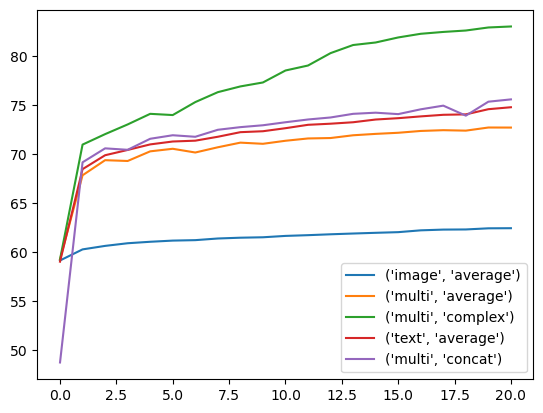

val_acc


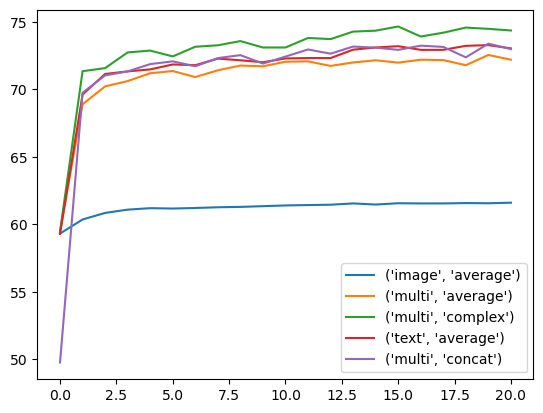

val_img_txt


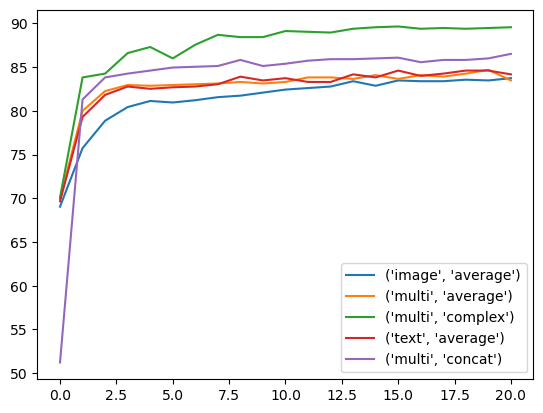

val_txt_only


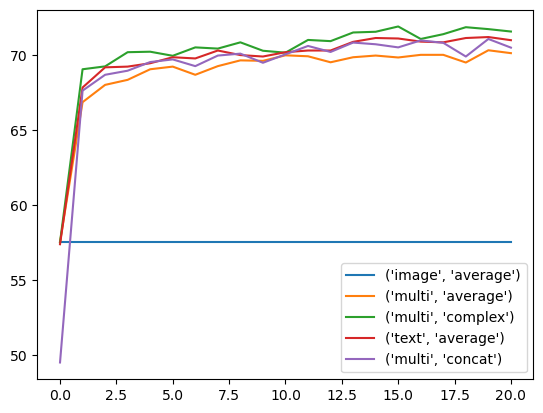

val_unseen_img


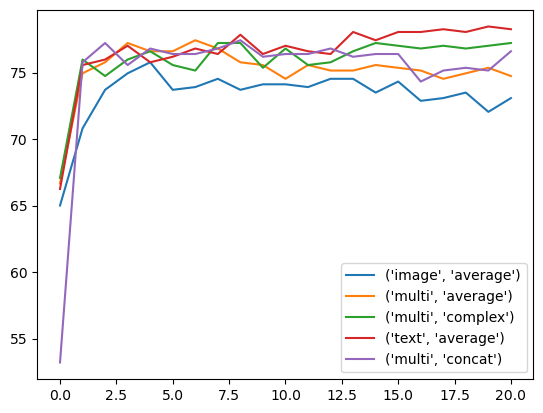

In [33]:
demonstration(hyperdict)

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6133    0.9906    0.7575     29306
         1.0     0.8606    0.0852    0.1550     20010

    accuracy                         0.6232     49316
   macro avg     0.7369    0.5379    0.4563     49316
weighted avg     0.7136    0.6232    0.5131     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6133    0.9921    0.7580     20463
         1.0     0.8864    0.0893    0.1623     14058

    accuracy                         0.6245     34521
   macro avg     0.7498    0.5407    0.4602     34521
weighted avg     0.7245    0.6245    0.5154     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6096    0.9859    0.7534      4400
         1.0     0.7794    0.0731    0.1336      2997

    accuracy                         0.6161      7397
   macro avg     0.6945    0.5295    0.4435

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

Training Set:
              precision    recall  f1-score   support

         0.0     0.6133    0.9921    0.7580     20463
         1.0     0.8864    0.0893    0.1623     14058

    accuracy                         0.6245     34521
   macro avg     0.7498    0.5407    0.4602     34521
weighted avg     0.7245    0.6245    0.5154     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6169    0.9881    0.7596      4443
         1.0     0.8121    0.0775    0.1415      2955

    accuracy                         0.6244      7398
   macro avg     0.7145    0.5328    0.4505      7398
weighted avg     0.6949    0.6244    0.5127      7398

Validation Set with both Images and Texts:
              precision    recall  f1-score   support

         0.0     0.8478    0.9260    0.8852       716
         1.0     0.8121    0.6580    0.7270       348

    accuracy                         0.8383      1064
   macro avg     0.8299    0.7920    0.8061      1064
w

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

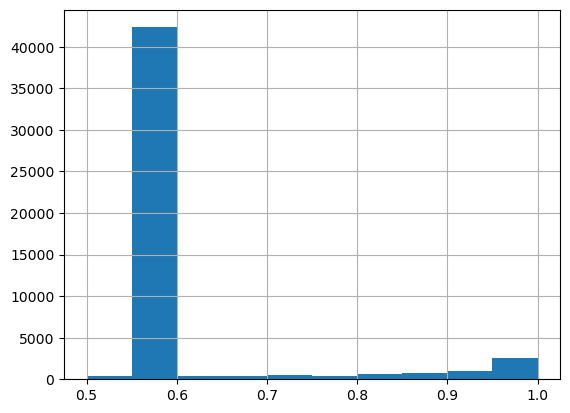

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7731    0.7618    0.7674     29306
         1.0     0.6584    0.6725    0.6654     20010

    accuracy                         0.7256     49316
   macro avg     0.7158    0.7171    0.7164     49316
weighted avg     0.7266    0.7256    0.7260     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7739    0.7623    0.7680     20463
         1.0     0.6614    0.6758    0.6685     14058

    accuracy                         0.7271     34521
   macro avg     0.7176    0.7190    0.7183     34521
weighted avg     0.7281    0.7271    0.7275     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7724    0.7634    0.7679      4400
         1.0     0.6585    0.6697    0.6640      2997

    accuracy                         0.7254      7397
   macro avg     0.7154    0.7165    0.7159

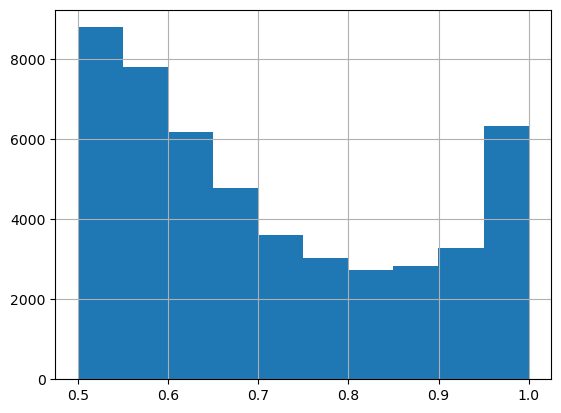

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8503    0.7971    0.8229     29306
         1.0     0.7278    0.7945    0.7597     20010

    accuracy                         0.7961     49316
   macro avg     0.7891    0.7958    0.7913     49316
weighted avg     0.8006    0.7961    0.7972     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8702    0.8161    0.8423     20463
         1.0     0.7545    0.8227    0.7872     14058

    accuracy                         0.8188     34521
   macro avg     0.8123    0.8194    0.8147     34521
weighted avg     0.8231    0.8188    0.8198     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8037    0.7593    0.7809      4400
         1.0     0.6731    0.7277    0.6994      2997

    accuracy                         0.7465      7397
   macro avg     0.7384    0.7435    0.7401

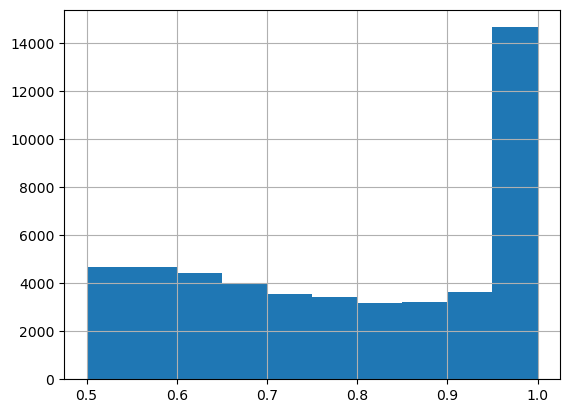

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7847    0.7759    0.7803     29306
         1.0     0.6771    0.6883    0.6826     20010

    accuracy                         0.7403     49316
   macro avg     0.7309    0.7321    0.7315     49316
weighted avg     0.7410    0.7403    0.7407     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7888    0.7797    0.7843     20463
         1.0     0.6847    0.6962    0.6904     14058

    accuracy                         0.7457     34521
   macro avg     0.7368    0.7380    0.7373     34521
weighted avg     0.7464    0.7457    0.7460     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7777    0.7711    0.7744      4400
         1.0     0.6681    0.6763    0.6722      2997

    accuracy                         0.7327      7397
   macro avg     0.7229    0.7237    0.7233 

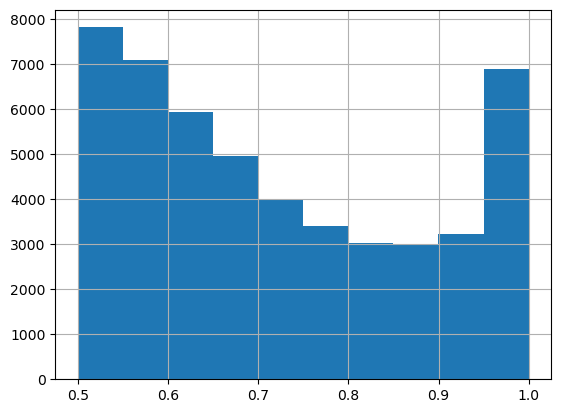

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7975    0.7678    0.7824     29306
         1.0     0.6775    0.7144    0.6955     20010

    accuracy                         0.7462     49316
   macro avg     0.7375    0.7411    0.7389     49316
weighted avg     0.7488    0.7462    0.7471     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8032    0.7734    0.7880     20463
         1.0     0.6871    0.7242    0.7052     14058

    accuracy                         0.7534     34521
   macro avg     0.7451    0.7488    0.7466     34521
weighted avg     0.7559    0.7534    0.7543     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7859    0.7593    0.7724      4400
         1.0     0.6634    0.6964    0.6795      2997

    accuracy                         0.7338      7397
   macro avg     0.7247    0.7278    0.7259 

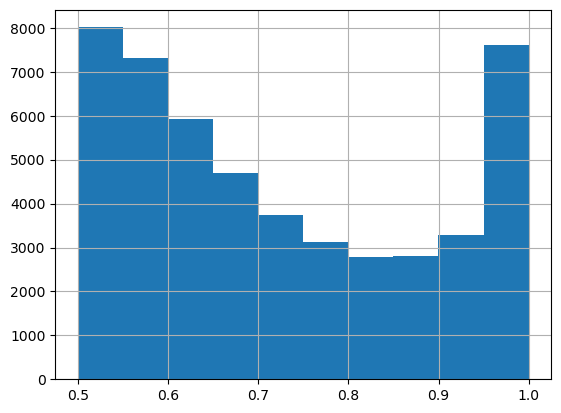

In [34]:
perform_results['O1'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='001/')

In [36]:
with open(args.save_dir+'002/hyperdict.p', 'rb') as fp:
    hyperdict = pickle.load(fp)

train_acc


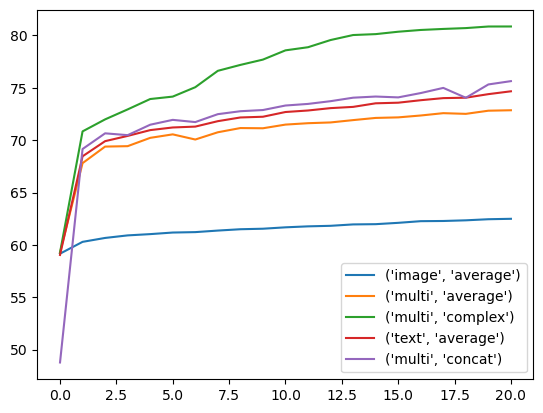

val_acc


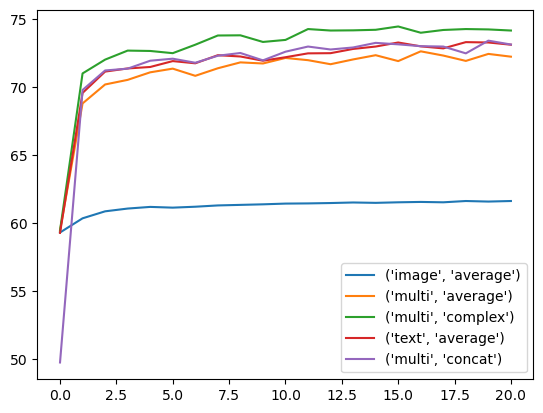

val_img_txt


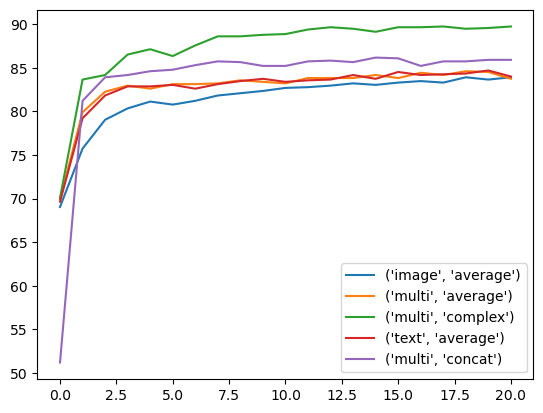

val_txt_only


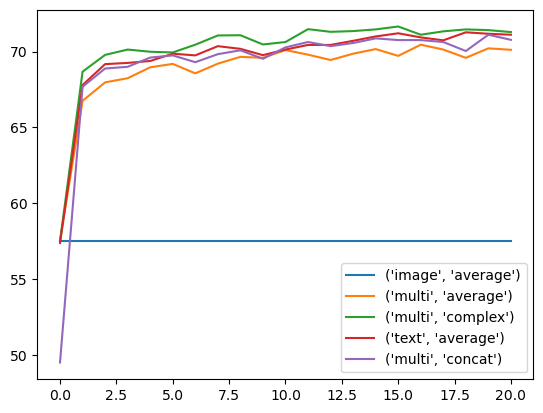

val_unseen_img


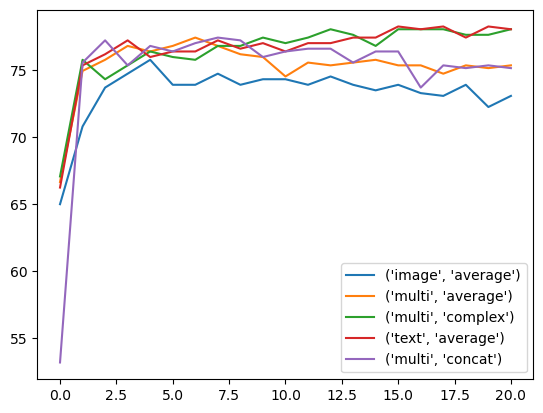

In [37]:
demonstration(hyperdict)

('image', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6129    0.9896    0.7570     29306
         1.0     0.8473    0.0846    0.1539     20010

    accuracy                         0.6224     49316
   macro avg     0.7301    0.5371    0.4554     49316
weighted avg     0.7080    0.6224    0.5123     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6128    0.9911    0.7573     20463
         1.0     0.8717    0.0884    0.1606     14058

    accuracy                         0.6235     34521
   macro avg     0.7422    0.5397    0.4589     34521
weighted avg     0.7182    0.6235    0.5143     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6099    0.9852    0.7534      4400
         1.0     0.7751    0.0747    0.1363      2997

    accuracy                         0.6163      7397
   macro avg     0.6925    0.5300    0.4449

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr


    Overall Accuracy: 62.24
    Training Set Accuracy: 62.35
    Validation Set Accuracy: 61.63
    Validation Set with both Images and Texts: 83.91
    Validation Set with only Texts: 57.53
    Validation Set with unseen Images: 73.91
    
Test Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6129    0.9896    0.7570     29306
         1.0     0.8473    0.0846    0.1539     20010

    accuracy                         0.6224     49316
   macro avg     0.7301    0.5371    0.4554     49316
weighted avg     0.7080    0.6224    0.5123     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6128    0.9911    0.7573     20463
         1.0     0.8717    0.0884    0.1606     14058

    accuracy                         0.6235     34521
   macro avg     0.7422    0.5397    0.4589     34521
weighted avg     0.7182    0.6235    0.5143     34521

Validation Set:
              precision    recall  f1-score   s

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metr

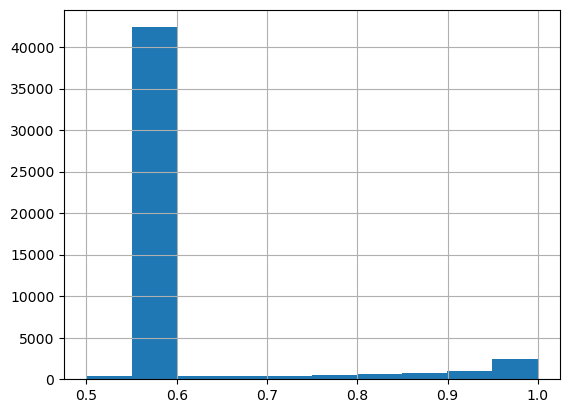

('multi', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7854    0.7355    0.7596     29306
         1.0     0.6456    0.7056    0.6743     20010

    accuracy                         0.7234     49316
   macro avg     0.7155    0.7206    0.7169     49316
weighted avg     0.7287    0.7234    0.7250     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7857    0.7338    0.7589     20463
         1.0     0.6465    0.7087    0.6762     14058

    accuracy                         0.7236     34521
   macro avg     0.7161    0.7213    0.7175     34521
weighted avg     0.7290    0.7236    0.7252     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7844    0.7443    0.7638      4400
         1.0     0.6508    0.6997    0.6744      2997

    accuracy                         0.7262      7397
   macro avg     0.7176    0.7220    0.7191

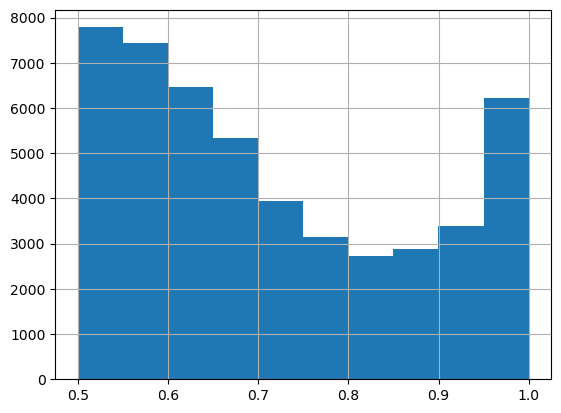

('multi', 'complex')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8405    0.7873    0.8130     29306
         1.0     0.7149    0.7811    0.7465     20010

    accuracy                         0.7848     49316
   macro avg     0.7777    0.7842    0.7798     49316
weighted avg     0.7895    0.7848    0.7860     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8575    0.8020    0.8288     20463
         1.0     0.7366    0.8059    0.7697     14058

    accuracy                         0.8036     34521
   macro avg     0.7970    0.8040    0.7992     34521
weighted avg     0.8082    0.8036    0.8047     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8001    0.7605    0.7798      4400
         1.0     0.6722    0.7211    0.6958      2997

    accuracy                         0.7445      7397
   macro avg     0.7361    0.7408    0.7378

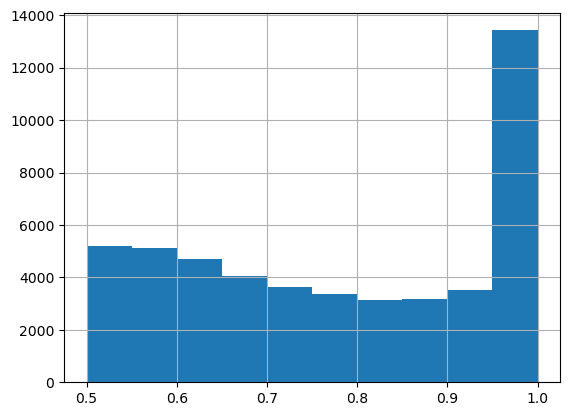

('text', 'average')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8100    0.7273    0.7664     29306
         1.0     0.6526    0.7501    0.6979     20010

    accuracy                         0.7366     49316
   macro avg     0.7313    0.7387    0.7322     49316
weighted avg     0.7461    0.7366    0.7386     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8131    0.7303    0.7695     20463
         1.0     0.6581    0.7556    0.7035     14058

    accuracy                         0.7406     34521
   macro avg     0.7356    0.7429    0.7365     34521
weighted avg     0.7499    0.7406    0.7426     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8056    0.7264    0.7640      4400
         1.0     0.6490    0.7427    0.6927      2997

    accuracy                         0.7330      7397
   macro avg     0.7273    0.7346    0.7283 

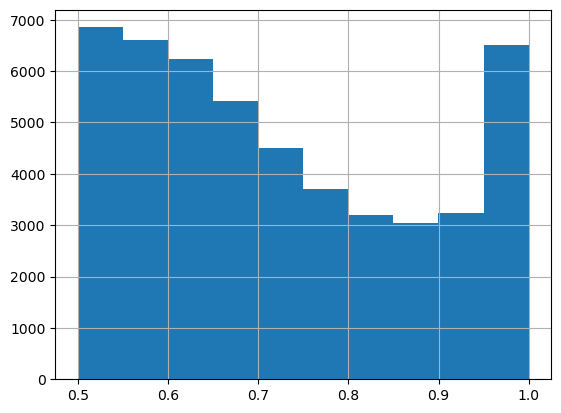

('multi', 'concat')

Validation Set:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8004    0.7641    0.7818     29306
         1.0     0.6761    0.7209    0.6978     20010

    accuracy                         0.7466     49316
   macro avg     0.7382    0.7425    0.7398     49316
weighted avg     0.7499    0.7466    0.7477     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8059    0.7689    0.7870     20463
         1.0     0.6847    0.7305    0.7068     14058

    accuracy                         0.7533     34521
   macro avg     0.7453    0.7497    0.7469     34521
weighted avg     0.7566    0.7533    0.7543     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7877    0.7570    0.7720      4400
         1.0     0.6626    0.7004    0.6809      2997

    accuracy                         0.7341      7397
   macro avg     0.7251    0.7287    0.7265 

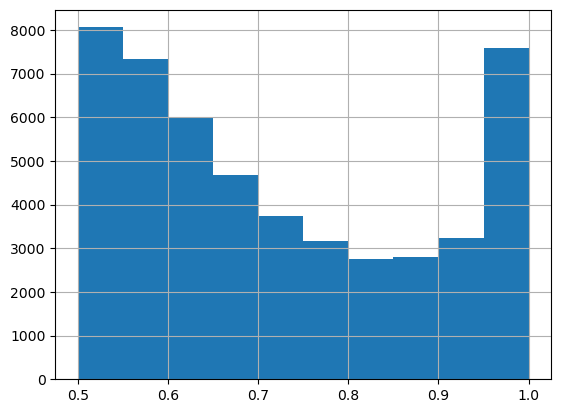

In [38]:
perform_results['O2'] = statistics_F1(hyperdict, stored_data, df, labs, subfolder='002/')

## Zero-shot Classification with Embeddings

In [39]:
embeddings = {}
for v in ['O1', 'O2']:
    embeddings[v] = {}
    for l in ['L2', 'L1', 'L0']:
        embeddings[v][l] = {}
        for t in ['val', 'test']:
            embeddings[v][l][t] = {}

In [40]:
embeddings

{'O1': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}},
 'O2': {'L2': {'val': {}, 'test': {}},
  'L1': {'val': {}, 'test': {}},
  'L0': {'val': {}, 'test': {}}}}

### Option 1

In [41]:
args

Namespace(model_state_file='MLP_classifier.pth', save_dir='model_storage/CLIP16/', embedding_size=512, early_stopping_criteria=20, num_epochs=20, seed=42, batch_size=32, embedding_type='multi', fusion_type='concat', hidden_dim=128, learning_rate=5e-05, l2=1e-05, dropout_p=0.1, catch_keyboard_interrupt=True, device='cuda', cuda=True, verbose=True)

In [42]:
args.embedding_type = 'multi'
args.fusion_type = 'complex'

In [43]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '001/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file, map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [44]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [45]:
labs = {}
labs['txt_emb'] = stored_data['lab_emb']
empty_img_emb = stored_data['empty_img_emb']
labs['img_emb'] = torch.vstack([empty_img_emb] * labs['txt_emb'].shape[0])

In [46]:
labs['img_emb'].shape

torch.Size([2, 512])

In [47]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [48]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8847    0.7367    0.8040     29306
         1.0     0.6903    0.8594    0.7656     20010

    accuracy                         0.7865     49316
   macro avg     0.7875    0.7981    0.7848     49316
weighted avg     0.8058    0.7865    0.7884     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.9048    0.7543    0.8227     20463
         1.0     0.7121    0.8845    0.7890     14058

    accuracy                         0.8073     34521
   macro avg     0.8084    0.8194    0.8058     34521
weighted avg     0.8263    0.8073    0.8090     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8387    0.6998    0.7630      4400
         1.0     0.6455    0.8025    0.7155      2997

    accuracy                         0.7414      7397
   macro avg     0.7421    0.7511    0

In [49]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [50]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [51]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.6573    0.8805    0.7527     29306
         1.0     0.6519    0.3277    0.4361     20010

    accuracy                         0.6562     49316
   macro avg     0.6546    0.6041    0.5944     49316
weighted avg     0.6551    0.6562    0.6243     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.6562    0.8777    0.7510     20463
         1.0     0.6501    0.3308    0.4385     14058

    accuracy                         0.6550     34521
   macro avg     0.6532    0.6042    0.5947     34521
weighted avg     0.6537    0.6550    0.6237     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.6571    0.8864    0.7547      4400
         1.0     0.6580    0.3210    0.4315      2997

    accuracy                         0.6573      7397
   macro avg     0.6576    0.6037    0

In [52]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [53]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [54]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O1']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O1']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.5965    0.0559    0.1022     29306
         1.0     0.4059    0.9446    0.5678     20010

    accuracy                         0.4165     49316
   macro avg     0.5012    0.5003    0.3350     49316
weighted avg     0.5192    0.4165    0.2911     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.5963    0.0557    0.1018     20463
         1.0     0.4074    0.9452    0.5694     14058

    accuracy                         0.4179     34521
   macro avg     0.5019    0.5004    0.3356     34521
weighted avg     0.5194    0.4179    0.2922     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.5826    0.0577    0.1050      4400
         1.0     0.4044    0.9393    0.5654      2997

    accuracy                         0.4149      7397
   macro avg     0.4935    0.4985    0

### Option 2

In [55]:
classifier = MLPClassifier(embedding_size=args.embedding_size, 
                        hidden_dim=args.hidden_dim, 
                        embedding_type=args.embedding_type, 
                        fusion_type=args.fusion_type,
                        num_classes=len(labels), 
                        dropout_p=args.dropout_p).to(args.device)
classifier.load_state_dict(torch.load(args.save_dir + '002/' + args.embedding_type + "_" + args.fusion_type + "_" + args.model_state_file,map_location=torch.device('cpu')))
classifier.eval()

MLPClassifier(
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc_concat): Linear(in_features=1024, out_features=128, bias=True)
  (fc_complex): Linear(in_features=2560, out_features=1024, bias=True)
)

In [56]:
new_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type)))))))
new_emb.shape

torch.Size([49316, 128])

In [57]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_concat(F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type)))))))
new_lab_emb.shape

torch.Size([2, 128])

In [58]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L2']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L2']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.8722    0.7325    0.7962     29306
         1.0     0.6826    0.8428    0.7543     20010

    accuracy                         0.7772     49316
   macro avg     0.7774    0.7876    0.7753     49316
weighted avg     0.7953    0.7772    0.7792     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.8892    0.7484    0.8127     20463
         1.0     0.7024    0.8643    0.7749     14058

    accuracy                         0.7956     34521
   macro avg     0.7958    0.8063    0.7938     34521
weighted avg     0.8131    0.7956    0.7973     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.8325    0.7002    0.7606      4400
         1.0     0.6431    0.7931    0.7103      2997

    accuracy                         0.7379      7397
   macro avg     0.7378    0.7467    0

In [59]:
new_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(stored_data, args.embedding_type, args.fusion_type))))
new_emb.shape

torch.Size([49316, 1024])

In [60]:
new_lab_emb = F.relu(classifier.dropout(classifier.fc_complex(prepare_embedding(labs, args.embedding_type, args.fusion_type))))
new_lab_emb.shape

torch.Size([2, 1024])

In [61]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L1']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L1']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.7702    0.7581    0.7641     29306
         1.0     0.6537    0.6688    0.6612     20010

    accuracy                         0.7219     49316
   macro avg     0.7120    0.7135    0.7127     49316
weighted avg     0.7230    0.7219    0.7224     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.7750    0.7595    0.7672     20463
         1.0     0.6598    0.6790    0.6693     14058

    accuracy                         0.7267     34521
   macro avg     0.7174    0.7193    0.7182     34521
weighted avg     0.7281    0.7267    0.7273     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.7607    0.7614    0.7610      4400
         1.0     0.6492    0.6483    0.6487      2997

    accuracy                         0.7156      7397
   macro avg     0.7049    0.7048    0

In [62]:
new_emb = prepare_embedding(stored_data, args.embedding_type, args.fusion_type)
new_emb.shape

torch.Size([49316, 2560])

In [63]:
new_lab_emb = prepare_embedding(labs, args.embedding_type, args.fusion_type)
new_lab_emb.shape

torch.Size([2, 2560])

In [64]:
MUL_LAB = util.cos_sim(new_lab_emb, new_emb)
pred_MUL = torch.argmax(MUL_LAB[:2,:], dim=0).float()
lab = torch.tensor(np.array(df['skepticism'])).to('cuda').float()
print('Zero-shot using new multi-modal embedding:')
embeddings['O2']['L0']['val'] = evaluate_dataset_F1(df, pred_MUL)
print('Zero-shot using new multi-modal embedding (test):')
embeddings['O2']['L0']['test'] = evaluate_dataset_F1(df, pred_MUL, val_set='test')

Zero-shot using new multi-modal embedding:
Overall Dataset:
              precision    recall  f1-score   support

         0.0     0.5965    0.0559    0.1022     29306
         1.0     0.4059    0.9446    0.5678     20010

    accuracy                         0.4165     49316
   macro avg     0.5012    0.5003    0.3350     49316
weighted avg     0.5192    0.4165    0.2911     49316

Training Set:
              precision    recall  f1-score   support

         0.0     0.5963    0.0557    0.1018     20463
         1.0     0.4074    0.9452    0.5694     14058

    accuracy                         0.4179     34521
   macro avg     0.5019    0.5004    0.3356     34521
weighted avg     0.5194    0.4179    0.2922     34521

Validation Set:
              precision    recall  f1-score   support

         0.0     0.5826    0.0577    0.1050      4400
         1.0     0.4044    0.9393    0.5654      2997

    accuracy                         0.4149      7397
   macro avg     0.4935    0.4985    0

In [65]:
results = {}
results['fusion'] = perform_results
results['new_embedding'] = embeddings

In [70]:
import pickle
with open(args.result_dir + 'results_F1.pkl', "wb") as fOut:
    pickle.dump(results, fOut, protocol=pickle.HIGHEST_PROTOCOL)